# Исследование объявлений о продаже квартир

Данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [34]:
import pandas as pd
import numpy as np

In [35]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'rooms'}>],
       [<AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'floor'}>],
       [<AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:title={'center':'cityCenters_nearest'}>],
       [<AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>,
        <AxesSubplot:title={'center':'ponds_nearest'}>],
       [<AxesSubplot:title={'center':'days_exposition'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], d

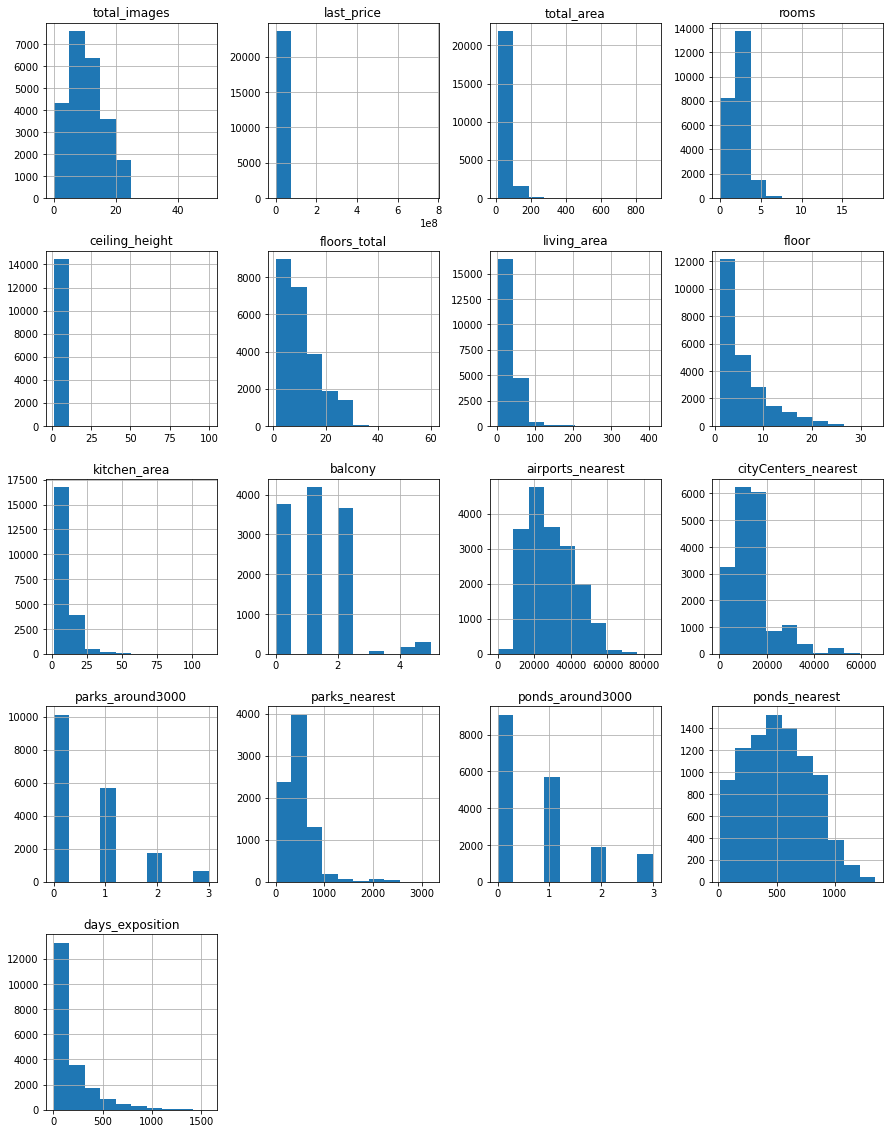

In [37]:
data.hist(figsize=(15,20))

In [38]:
# код ревьюера 
import datetime as dt

data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data['first_day_year'] = data['first_day_exposition'].dt.year
data[data['days_exposition'].isnull()].pivot_table(columns = 'first_day_year', values = 'total_area', aggfunc = 'count')

first_day_year,2014,2015,2016,2017,2018,2019
total_area,18,70,67,271,959,1796


### Предобработка данных

In [39]:
#поиск пустых значений
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
first_day_year              0
dtype: int64

In [40]:
#заполняем явные пустые значения
#заполняем пустые значения жилплощади (living_area) и площади кухни произведением общей площади к медианному соотношению общей площади жилплощади (площади кухни)
living_total_ratio = (data['living_area'] / data['total_area']).median()
kitchen_total_ratio = (data['kitchen_area'] / data['total_area']).median()
data.loc[data['living_area'].isna(), 'living_area'] = round((data['total_area'] * living_total_ratio), 1)
data.loc[data['kitchen_area'].isna(), 'kitchen_area'] = round((data['total_area'] * kitchen_total_ratio), 1)
#заполняем пустые значения kitchen_area медианным значением
data.loc[data['kitchen_area'].isna(), 'kitchen_area'] = data['kitchen_area'].median()
#заполняем пустые значения balcony. parks_around3000 и ponds_around3000 нулевым значением
data.loc[data['balcony'].isna(), 'balcony'] = 0
data.loc[data['parks_around3000'].isna(), 'parks_around3000'] = 0
data.loc[data['ponds_around3000'].isna(), 'ponds_around3000'] = 0
#заполняем пустые значения ceiling_height медианным, округленным до 2 знаков
data.loc[data['ceiling_height'].isna(), 'ceiling_height'] = data['ceiling_height'].median()
#избавляемся от строк с пустыми значениями в locality_name и 'floors_total'
data = data.dropna(subset=['locality_name', 'floors_total'])

In [41]:
dates = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
years = dates.dt.year.unique()
for year in years:
    print(year)
    print(data.loc[dates.dt.year == year, 'days_exposition'].describe())

2019
count    1083.000000
mean       30.931671
std        23.828503
min         1.000000
25%        12.000000
50%        23.000000
75%        45.000000
max       110.000000
Name: days_exposition, dtype: float64
2018
count    7529.000000
mean       94.249436
std        85.151323
min         3.000000
25%        34.000000
50%        64.000000
75%       130.000000
max       465.000000
Name: days_exposition, dtype: float64
2015
count    1096.000000
mean      651.603102
std       319.116967
min       182.000000
25%       392.000000
50%       580.500000
75%       888.000000
max      1512.000000
Name: days_exposition, dtype: float64
2017
count    7890.000000
mean      159.158428
std       153.304771
min         3.000000
25%        45.000000
50%       103.000000
75%       227.000000
max       825.000000
Name: days_exposition, dtype: float64
2016
count    2678.000000
mean      323.182226
std       257.529325
min         3.000000
25%       115.000000
50%       238.000000
75%       481.000000
max 

In [42]:
#проверяем датафрейм после обработки явных пустых значений
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment            20805
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5524
cityCenters_nearest      5501
parks_around3000            0
parks_nearest           15535
ponds_around3000            0
ponds_nearest           14529
days_exposition          3171
first_day_year              0
dtype: int64

In [43]:
#выявляем неявные дубликаты
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [44]:
#убираем неявные дубликаты в географических названиях
#меняем в географических названиях буквы "ё" на "е"
data['locality_name'] = data['locality_name'].apply(lambda x: x.replace('посёлок', 'поселок'))
data['locality_name'] = data['locality_name'].apply(lambda x: x.replace('городской поселок', 'поселок городского типа'))
#меняем название "поселок Мурино" на "Мурино"
data[data['locality_name'] == 'поселок Мурино'] = data[data['locality_name'] == 'поселок Мурино'].apply(lambda x: x.replace('поселок Мурино', 'Мурино'))
#проверяем уникальность значений
data['locality_name'].unique()

array(['Санкт-Петербург', 'поселок Шушары',
       'поселок городского типа Янино-1', 'поселок Парголово', 'Мурино',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', 'деревня Кудрово',
       'Коммунар', 'Колпино', 'поселок городского типа Красный Бор',
       'Гатчина', 'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'поселок Металлострой',
       'поселок городского типа Лебяжье',
       'поселок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'поселок Аннино',
       'поселок городского типа Ефимовский', 'поселок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'поселок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', 'поселок Новый Свет',

In [45]:
#меняем типы данных
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data['floors_total'] = data['floors_total'].astype('int')
data['balcony'] = data['balcony'].astype('int')
data['ponds_around3000'] = data['ponds_around3000'].astype('int')
data['parks_around3000'] = data['parks_around3000'].astype('int')
data['is_apartment'] = data['is_apartment'].astype('bool')
#проверяем корректность типов данных
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  float64       
 2   total_area            23565 non-null  float64       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  int64         
 5   ceiling_height        23565 non-null  float64       
 6   floors_total          23565 non-null  int32         
 7   living_area           23565 non-null  float64       
 8   floor                 23565 non-null  int64         
 9   is_apartment          23565 non-null  bool          
 10  studio                23565 non-null  bool          
 11  open_plan             23565 non-null  bool          
 12  kitchen_area          23565 non-null  float64       
 13  balcony         

In [46]:
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,first_day_year
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,True,...,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,2019
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,True,...,2,поселок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0,2018
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,True,...,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,2015
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,90.3,9,True,...,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424.0,2015
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,True,...,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,2018


In [47]:
#убираем аномалии
#минимум по жилой площади устанавливаем на уровне минимальной санитарной нормы, максимум на уровне 200 кв. м
data = data[(data['living_area'] >= 6) & (data['total_area'] <= 200)]
#пересчитываем ошибки в высоте потолков, устанавливаем минимум на уровне 2 м, максимум - 6 м 
data.loc[data['ceiling_height'] >= 20, 'ceiling_height'] = data.loc[data['ceiling_height'] >= 20, 'ceiling_height'] / 10
data = data[(data['ceiling_height'] >= 2) & (data['ceiling_height'] <= 6)]
#убираем объекты с очень высокой стоимостью более 250 млн.
data = data[data['last_price'] <= 250000000]
#убираем объекты с нулевым значением числа комнат и числом комнат более 7
data = data[(data['rooms'] > 0) & (data['rooms'] < 8)]

In [48]:
#изначально в датасете было 23699 строк, проверим, сколько строк осталось
print(f'Количество строк в обработанном датафрейме: {len(data)}')
print(f'Доля обработанного датасета от изначального: {round((len(data) / 23699 * 100), 1)}')

Количество строк в обработанном датафрейме: 23126
Доля обработанного датасета от изначального: 97.6


**Итоги предобработки:**
- заменены пустые значения на медиану: жилой площади (в зависимости от числа комнат), площади кухни, , высоты потолков
- заменены пустые значения на 0: количество парков и прудов в районе 3 км, число балконов
- удалены объекты без указания населенного пункта и общего числа этажей в доме
- на дату изменен тип данных столбца с днем публикации объявления
- на целые числа заменен тип значений общего число балконов, парков и прудов в районе 3 км
- на булевые значения заменен тип столбца "апартаменты"
- убраны аномалии и выбросы в столбцах жилой площади, высоты потолков, стоимости квартиры, числа комнат
- в результате предварительной обработки данных осталось чуть больше 23 тыс. строк (-2,4% по сравнению с изначальным датасетом)

### Посчитайте и добавьте в таблицу новые столбцы

In [49]:
#новые столбцы: цена квадратного метра, день недели, месяц и год публикации объявления
data['sq_m_price'] = round(data['last_price'] / data['total_area'], 2)
data['dow_exposition'] = data['first_day_exposition'].dt.dayofweek
data['month_exposition'] = data['first_day_exposition'].dt.month
data['year_exposition'] = data['first_day_exposition'].dt.year

data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,first_day_year,sq_m_price,dow_exposition,month_exposition,year_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,True,...,1,482.0,2,755.0,NaN,2019,120370.37,3,3,2019
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,True,...,0,NaN,0,NaN,81.0,2018,82920.79,1,12,2018
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,True,...,1,90.0,2,574.0,558.0,2015,92785.71,3,8,2015
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,90.3,9,True,...,2,84.0,3,234.0,424.0,2015,408176.10,4,7,2015
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,True,...,2,112.0,1,48.0,121.0,2018,100000.00,1,6,2018


In [50]:
#добавим функцию по типологизации типа этажа
def floor_type(row):
    if row['floor'] == 1:
        return 'first'
    elif row['floor'] == row['floors_total']:
        return 'last'
    else:
        return 'other'
#применим функцию для определения типа этажа
data['floor_type'] = data.apply(floor_type, axis=1)

In [51]:
#добавим столбец: расстояние от центра в км
data['center_nearest_km'] = round((data['cityCenters_nearest'] / 1000), 0)
#проверим итоговый датафрейм
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,first_day_year,sq_m_price,dow_exposition,month_exposition,year_exposition,floor_type,center_nearest_km
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,True,...,2,755.0,NaN,2019,120370.37,3,3,2019,other,16.0
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,True,...,0,NaN,81.0,2018,82920.79,1,12,2018,first,19.0
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,True,...,2,574.0,558.0,2015,92785.71,3,8,2015,other,14.0
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,90.3,9,True,...,3,234.0,424.0,2015,408176.10,4,7,2015,other,7.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,True,...,1,48.0,121.0,2018,100000.00,1,6,2018,other,8.0


**Итоги:** 
Добавлены значения:
- цены за кв. м, 
- дня, месяца и года публикации объявления
- типа этажа

### Проведите исследовательский анализ данных

**Изучение и описание основных параметров**

In [52]:
#описание основных числовых параметров квартиры
data[['total_area', 'living_area', 'kitchen_area', 'last_price', 'rooms', 'ceiling_height', 'floor', 'floors_total', 'parks_nearest', 'ponds_nearest', 'airports_nearest']].describe()

,total_area,living_area,kitchen_area,last_price,rooms,ceiling_height,floor,floors_total,parks_nearest,ponds_nearest,airports_nearest
count,23126.000000,23126.000000,23126.000000,2.312600e+04,23126.000000,23126.000000,23126.000000,23126.000000,7844.000000,8799.000000,17688.000000
mean,58.375908,33.395285,10.310753,6.017246e+06,2.050333,2.692147,5.865779,10.665182,491.464049,520.638254,28856.888286
std,26.389545,17.243721,5.320251,5.574548e+06,0.977131,0.209928,4.860917,6.575067,342.554632,277.789241,12679.397394
min,12.000000,6.000000,1.300000,1.219000e+04,1.000000,2.000000,1.000000,1.000000,1.000000,13.000000,0.000000
25%,40.000000,19.000000,7.000000,3.441000e+06,1.000000,2.600000,2.000000,5.000000,288.000000,297.000000,18517.500000
50%,52.000000,30.000000,9.000000,4.600000e+06,2.000000,2.650000,4.000000,9.000000,455.000000,505.000000,26878.500000
75%,69.000000,42.000000,11.850000,6.700000e+06,3.000000,2.700000,8.000000,16.000000,613.000000,733.000000,37406.250000
max,200.000000,164.700000,93.200000,1.350000e+08,7.000000,6.000000,33.000000,60.000000,3190.000000,1344.000000,84869.000000


array([[<AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'kitchen_area'}>],
       [<AxesSubplot:title={'center':'rooms'}>,
        <AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floor'}>],
       [<AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_nearest'}>],
       [<AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

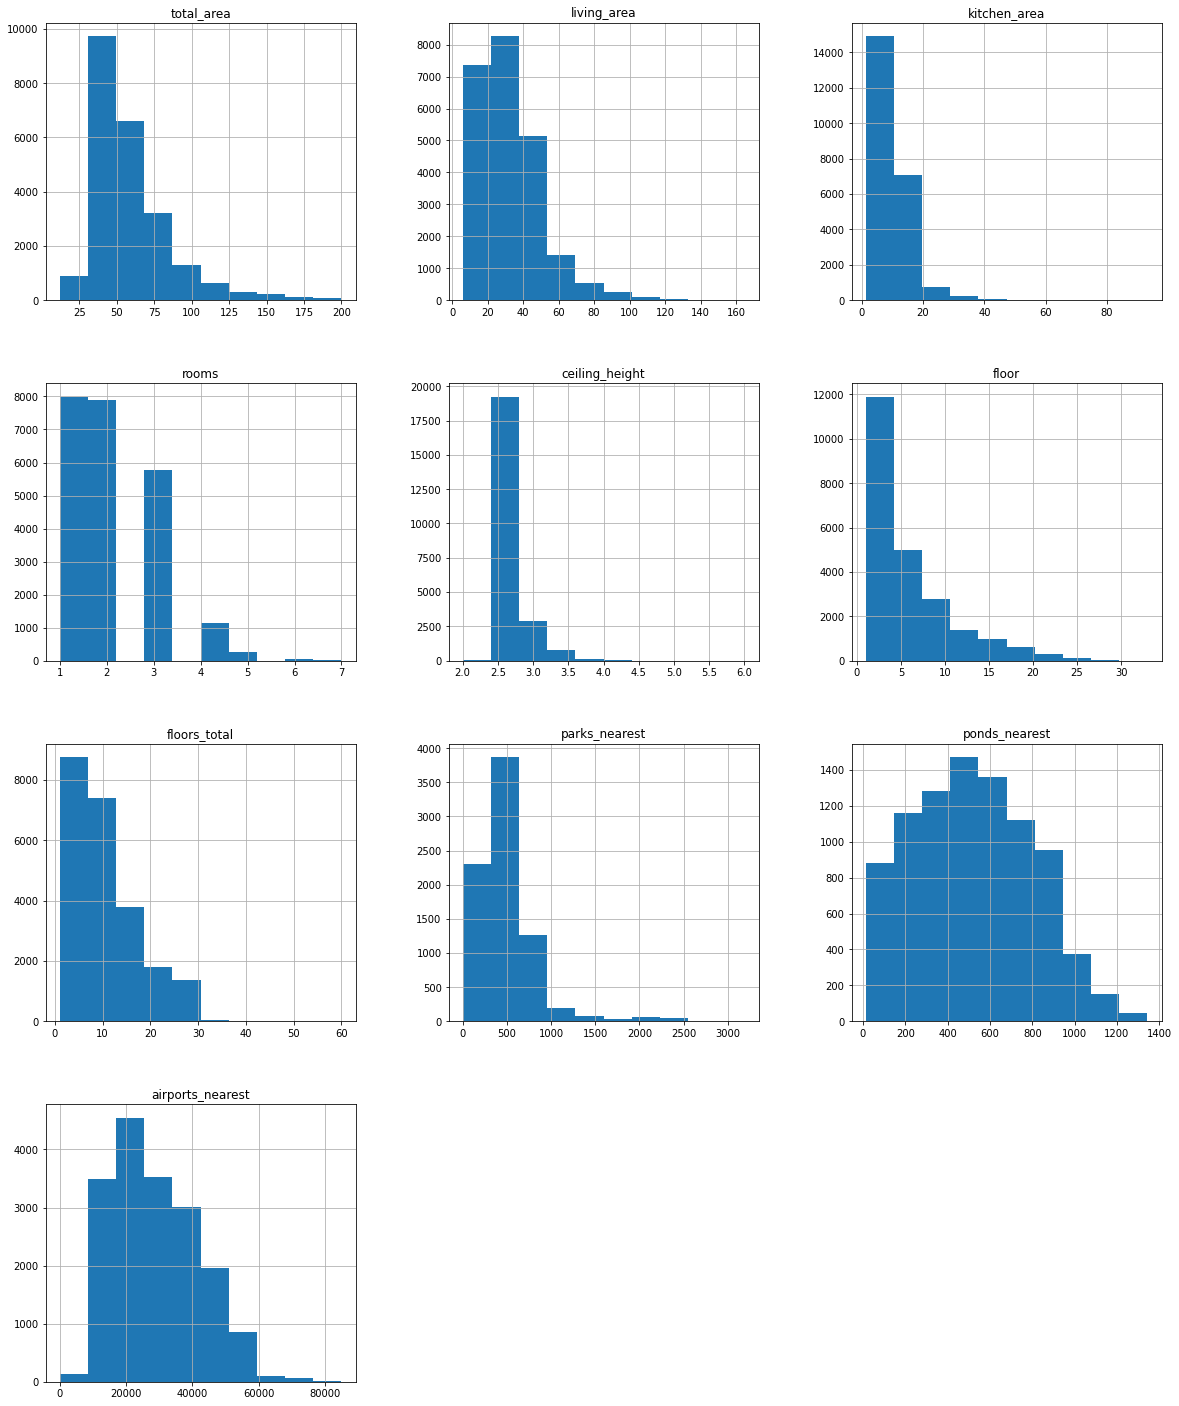

In [53]:
data[['total_area', 'living_area', 'kitchen_area', 'rooms', 'ceiling_height', 'floor', 'floors_total', 'parks_nearest', 'ponds_nearest', 'airports_nearest']].hist(figsize=(20, 25))

<AxesSubplot:>

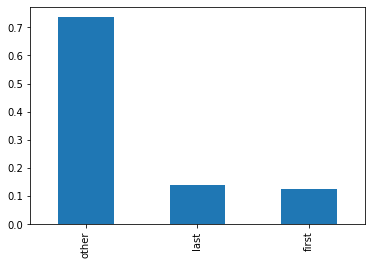

In [54]:
#более 70% объявлений приходится на объявления с типом этажа "другой"
data['floor_type'].value_counts(normalize=True).plot(kind='bar')

In [55]:
#как правило, объявления о продаже размещаются в будни, чаще всего во вт или чт
dow_expo_grouped = data.groupby('dow_exposition')['dow_exposition'].count()
dow_expo_grouped

dow_exposition
0    3545
1    4095
2    3866
3    4186
4    3892
5    1887
6    1655
Name: dow_exposition, dtype: int64

<AxesSubplot:xlabel='dow_exposition'>

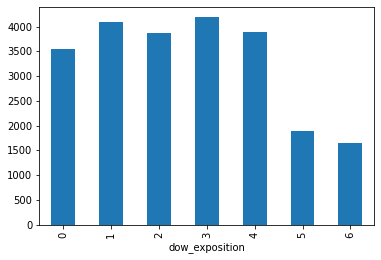

In [56]:
dow_expo_grouped.plot(kind='bar')

In [57]:
#пик размещений приходится на февраль-март и сентябрь-ноябрь
month_expo_grouped = data.groupby('month_exposition')['month_exposition'].count()
month_expo_grouped

month_exposition
1     1455
2     2596
3     2532
4     2317
5     1239
6     1724
7     1646
8     1705
9     1927
10    2075
11    2307
12    1603
Name: month_exposition, dtype: int64

<AxesSubplot:xlabel='month_exposition'>

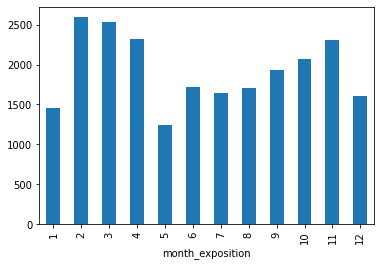

In [58]:
month_expo_grouped.plot(kind='bar')

**Портрет типичной квартиры на продажу в агломерации Санкт-Петербурга:**
   - общая площадь 40-70 кв. м, жилая площадь - 18-42 кв. м, площадь кухни 7-11 кв. м
   - цена - 3,4-6,7 млн. рублей
   - 1-3 комнаты
   - высота потолков 2,6-2,7 м
   - 2-8 этаж в доме с общей этажностью 5-16 этажей
   - ближайший парк в 300-600 м, пруд - в 300-700 м, аэропорт - в 19-37 км
   - объявление опубликовано в будни в феврале-марте или осенью

**Как быстро продавались квартиры (столбец days_exposition)?**

In [59]:
#как правило, продажа квартиры может занять чуть больше трех месяцев. Необычно долгие продажи характерны для объектов, которые висят на сайте более 800 дней. Необычно быстрые продажи - менее 6 дней
data['days_exposition'].describe()

count    20024.000000
mean       180.154614
std        218.683830
min          1.000000
25%         45.000000
50%         95.000000
75%        230.250000
max       1580.000000
Name: days_exposition, dtype: float64

<AxesSubplot:>

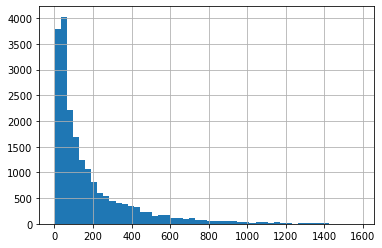

In [60]:
data['days_exposition'].hist(bins=50)

<AxesSubplot:>

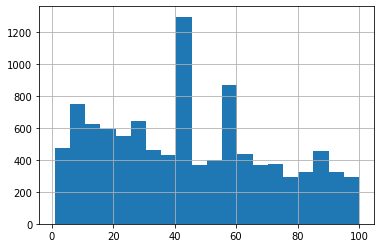

In [61]:
#визуализация продаж, занявших менее полугода
data.loc[data['days_exposition'] <= 100, 'days_exposition'].hist(bins=20)

При визуализации продаж, занявших по времении до 100 дней, выявлены пики в районе 45 и 60 и 90 дней. Скорее всего, пики связаны с тем, что автоматическое снятие объявлений происходит через 45, 60 и 90 дней в зависимости от стоимости.

In [62]:
#удаляем пики, которые не были фактическими продажами
days_expo = data.loc[(data['days_exposition'] != 45) & (data['days_exposition'] != 60) & (data['days_exposition'] != 90), 'days_exposition']
days_expo.describe()

count    19490.000000
mean       183.446691
std        220.740898
min          1.000000
25%         44.000000
50%        100.000000
75%        237.000000
max       1580.000000
Name: days_exposition, dtype: float64

**Ответ**

При визуализации продаж, занявших по времении до 100 дней, выявлены пики в районе 45 и 60 и 90 дней. Скорее всего, пики связаны с тем, что автоматическое снятие объявлений происходит через 45, 60 и 90 дней в зависимости от стоимости. После удаления пиков, получилось следующее:
- как правило, продажа недвижимости занимала около 3,5 месяцев (104 дня)
- относительно быстрыми продажами можно считать продажи до 1,5 месяцев (44 дня)
- относительно медленными - продажи, занявшие более 8 месяцев (242 дня). 

**Какие факторы больше всего влияют на общую (полную) стоимость объекта?**

In [63]:
#создаем датафрейм с ценами и факторами
price_factors = data[['last_price', 
                   'total_area', 'living_area', 
                   'kitchen_area', 'rooms', 
                   'floor_type', 'dow_exposition', 
                   'month_exposition', 'year_exposition']]
#считаем корреляцию стоимости с общей площадью, жилой площадью и площадью кухни
correlation = price_factors[['last_price', 
                   'total_area', 'living_area', 
                   'kitchen_area']].corr()
correlation.style.background_gradient() 

,last_price,total_area,living_area,kitchen_area
last_price,1.000000,0.715786,0.610476,0.578573
total_area,0.715786,1.000000,0.929614,0.600346
living_area,0.610476,0.929614,1.000000,0.376292
kitchen_area,0.578573,0.600346,0.376292,1.000000


**Вывод:** наиболее сильная связь наблюдается между стоимостью и общей площадью объекта недвижимости. Связь между жилой площадью и площадью кухни также является значимой.

**Графики рассеивания цен и общей площади, жилой площади и площади кухни**

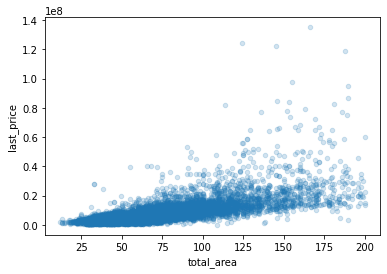

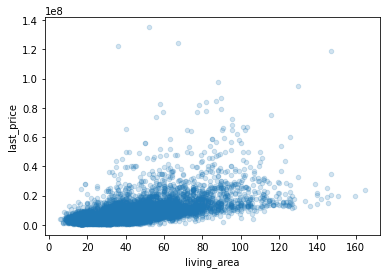

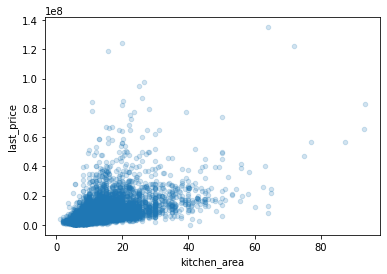

In [64]:
cols = price_factors.columns
for col in cols[1:4]:
    price_factors.plot(x=col, y='last_price', kind='scatter', alpha=0.2)

   rooms  count        mean
0      1   7997   3827340.0
1      2   7891   5551710.0
2      3   5761   7977280.0
3      4   1132  11844920.0
4      5    264  15106530.0
5      6     61  16586030.0
6      7     20  18682000.0 


  floor_type  count       mean
0      first   2873  4644230.0
1       last   3240  5727000.0
2      other  17013  6304380.0 


   dow_exposition  count       mean
0               0   3545  6070290.0
1               1   4095  6021640.0
2               2   3866  5992980.0
3               3   4186  6262080.0
4               4   3892  5887180.0
5               5   1887  5907130.0
6               6   1655  5761580.0 


    month_exposition  count       mean
0                  1   1455  6034040.0
1                  2   2596  6123710.0
2                  3   2532  5834650.0
3                  4   2317  5985850.0
4                  5   1239  6007490.0
5                  6   1724  5833010.0
6                  7   1646  6053170.0
7                  8   1705  6065180.0
8   

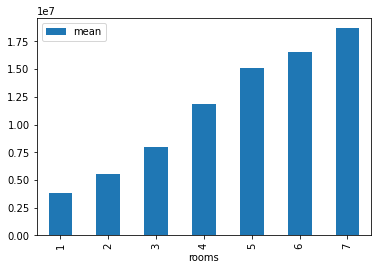

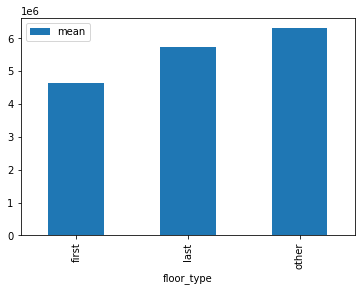

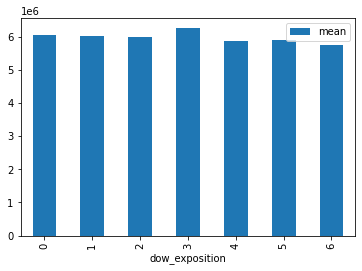

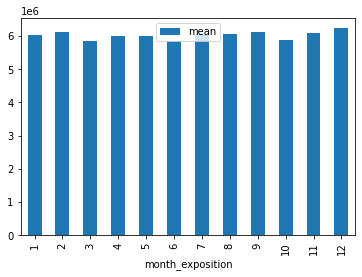

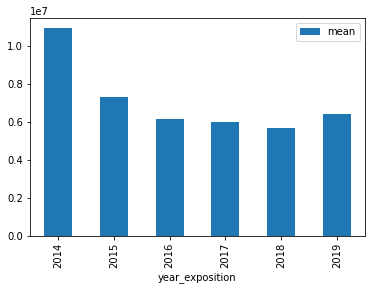

In [65]:
#сводные таблицы и графики по средней стоимости объекта недвижимости в зависимости от количества комнат, типа этажа, дня и месяца публикации объявления
for col in cols[4:]:
    grouped = pd.pivot_table(price_factors, index=col, values = 'last_price', aggfunc=['count', 'mean']).reset_index()
    grouped.columns = [col, 'count', 'mean']
    grouped['mean'] = round(grouped['mean'], -1)
    print(grouped, '\n\n')
    grouped.plot(x=col, y='mean', kind='bar')

Примечательно, что средняя стоимость квартир значительно выше в 2014 г. Это можно объяснить двумя обстоятельствами. В 2014 г. сервис по недвижимости Яндекса мог быть не так популярен в Санкт-Петербурге и Ленинградской области или в датасете содержатся значения с конца 2014 г. Также зафиксировано небольшое количество объявлений в 2019 г. (почти в 7 раз меньше, чем в 2017-2018 гг.), возможно данные собраны за неполный год. Проверим день и месяц публикации объявления в 2014 и 2019 гг.

In [66]:
data['first_day_exposition'].describe(datetime_is_numeric=True)

count                            23126
mean     2017-11-11 04:55:42.523566592
min                2014-11-27 00:00:00
25%                2017-05-15 00:00:00
50%                2017-12-13 12:00:00
75%                2018-08-27 00:00:00
max                2019-05-03 00:00:00
Name: first_day_exposition, dtype: object

Данные за 2014 и 2019 гг. не вполне репрезентативны, поскольку не отражают данные за весь год. Если говорить о периоде 2015-2018 гг., то наблюдается снижение средней стоимости квартир в Санкт-Петербурге.

**Выводы:**
- с увеличением числа комната увеличивается стоимость объекта недвижимости, при этом незначительно количество объектов с 5 комнатами и более 
- объекты недвижимости на первом этаже дешевле, затем идут объекты на последнем этаже, квартиры на других этажах являются самыми дорогими
- разница в цене между квартирами по дню публикации незначительна: как правило, объявления, опубликованные с пятницы по воскресенье, ниже по стоимости. Возможно, данные объявления публикуют непосредственно собственники в свободное от работы время. Объявления, появившиеся в будни, продаются при помощи риэлторов, которые берут комиссию от сделки.
- разница в цене между квартирами по месяцу публикации также незначительна: как правило, объявления, опубликованные в марте-июне, ниже по стоимости. Также снижение цен наблюдается в октябре.
- в 2015-2018 гг. наблюдается снижение средней стоимости квартир в агломерации Санкт-Петербурга.

**Данные о средней цене квадратного метра в 10 населенных пунктах с наибольшим количеством объявлений**

In [67]:
#забираем названия 10 населенных пунктов с наибольшим количеством объявлений
top10_localities = list(data['locality_name'].value_counts().head(10).index)
top10_mean_price_dict = {}
for locality in top10_localities:
    top10_mean_price_dict[locality] = round(data.loc[data['locality_name'] == locality, 'sq_m_price'].mean(), -1)
top10_data = pd.DataFrame.from_dict(top10_mean_price_dict, orient = 'index', columns = ['mean_sq_m_price'])
top10_data.sort_values(by='mean_sq_m_price', ascending = False)

,mean_sq_m_price
Санкт-Петербург,113260.0
Пушкин,103120.0
деревня Кудрово,92300.0
поселок Парголово,90450.0
Мурино,85470.0
поселок Шушары,78280.0
Колпино,75330.0
Гатчина,68750.0
Всеволожск,68620.0
Выборг,58140.0


**Выводы**: 
- самая высокая стоимость квадратного метра наблюдается в Санкт-Петербурге, Пушкине и Кудрове
- самая низкая стоимость - в Гатчине, Всеволожске и Выборге

In [68]:
spb_data = data[data['locality_name'] == 'Санкт-Петербург']
spb_data.isna().sum()

total_images               0
last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height             0
floors_total               0
living_area                0
floor                      0
is_apartment               0
studio                     0
open_plan                  0
kitchen_area               0
balcony                    0
locality_name              0
airports_nearest          79
cityCenters_nearest       58
parks_around3000           0
parks_nearest           8240
ponds_around3000           0
ponds_nearest           7601
days_exposition         2013
first_day_year             0
sq_m_price                 0
dow_exposition             0
month_exposition           0
year_exposition            0
floor_type                 0
center_nearest_km         58
dtype: int64

In [69]:
spb_data = spb_data.dropna(subset = ['cityCenters_nearest'])
spb_data['center_nearest_km'] = spb_data['center_nearest_km'].astype('int')
grouped_km = pd.pivot_table(spb_data, index = 'center_nearest_km', values = 'sq_m_price', aggfunc=['count', 'mean']).reset_index()
grouped_km.columns = ['km', 'count', 'mean_sq_m_price']
grouped_km

,km,count,mean_sq_m_price
0,0,25,223446.082000
1,1,171,148790.346901
2,2,285,149931.780105
3,3,338,120832.232041
4,4,665,128245.048617
5,5,860,137048.455337
6,6,571,147092.033940
7,7,407,154933.142924
8,8,580,124014.238724
9,9,588,113057.553929


<AxesSubplot:xlabel='km'>

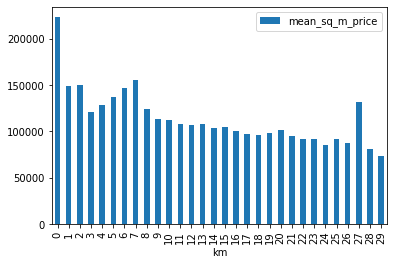

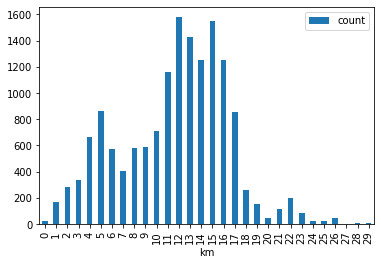

In [70]:
grouped_km.plot(kind='bar', x='km', y='mean_sq_m_price')
grouped_km.plot(kind='bar', x='km', y='count')

**Выводы:**
   - самые высокие цены наблюдаются в диапазоне 0-2 км от центра и 6-7 км. Возможно, падение цен в радиусе 3-5 км связано с тем, что квартиры находятся в исторических зданиях с устаревшими коммунальными системами и небольшим числом объектов социальной инфраструктуры (больницы, школы, детские сады и т.д.).
   - большинство квартир в объявлениях находятся в радиусе 11-16 км от центра (более 1000 объявлений на каждом километре)
   - наблюдается аномально высокая средняя стоимость квартир в 27 км от центра. Возможно, дело в том, что на таком удалении от центра города продавалось только два объекта, что не является репрезентативным.

### Общий вывод

- в датасете содержались и заменены пропущенные значения в столбцах, отражающих высоту потолков, жилую площадь, апартаменты, площадь кухни, число балконов, близости от парков, прудов и аэропортов, число дней публикации объявлений
- удалены пустые значения в столбцах с информацией об общем количестве этажей и названии населенного пункта
- для удобства дальнейшей работы, в части столбцов изменены типы данных
- удалены аномальные и большие значения, искажающие информацию о датасете
- добавлены новые столбцы с ценой одного квадратного метра; годе, месяце и дне публикации объявления; типе этажа квартиры, расстоянии от центра в км
- как правило, продажа занимает чуть больше 3 месяцев (95 дней), однако также распространены продажи в течение 45 и 60 дней
- цена квартиры имеет высокую корреляцию с общей и жилой площади, связь с площадью кухни также является значимой
- средняя цена с увеличением числа комнат также возрастает
- самые дорогие квартиры находятся не на первом и не на последнем этаже, самые дешевые - на первом
- средняя цена квартир, опубликованных в будни, несколько меньше по сравнению с объявлениями, опубликованными в выходные.
- средняя стоимость квартир несколько выше в феврале-апреле и осенью.
- в 2015-2018 гг. средняя стоимость квартир снижалась
- самая высокая стоимость квадратного метра наблюдается в Санкт-Петербурге (110 тыс. рублей), Пушкине (103 тыс. рублей) и Кудрове (92 тыс. рублей)
- самая низкая стоимость квадратного метра - в Гатчине (69 тыс. рублей), Всеволожске (68 тыс. рублей) и Выборге (57 тыс. рублей)
- больше половины объявлений содержат информацию о квартирах в Санкт-Петербурге. Самая высокая стоимость квартир наблюдается в радиусе 0-7 км от центра города. Большая часть квартир расположена в радиусе 11-16 км.

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения там, где это возможно
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  устранены неявные дубликаты в названиях населённых пунктов
- [x]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [x]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [x]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [x]  посчитано и добавлено в таблицу: месяц публикации объявления
- [x]  посчитано и добавлено в таблицу: год публикации объявления
- [x]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [x]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [x]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [x]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [x]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [x]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [x]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод